In [1]:
pip install tensorflow==1.15.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score
np.random.seed(42)

from matplotlib import style
style.use('fivethirtyeight')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
Root = "/content/drive/MyDrive/Deep_learning/Traffic_sign_classification"
os.chdir(Root)

In [5]:
data_dir = "/content/drive/MyDrive/Deep_learning/Traffic_sign_classification"
train_path = 'Train'
test_path = 'Test'

# Resizing the images to 30x30x3
IMG_HEIGHT = 30
IMG_WIDTH = 30
channels = 3

In [6]:
NUM_CATEGORIES = len(os.listdir(train_path))
NUM_CATEGORIES

43

In [7]:
# Label Overview
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }

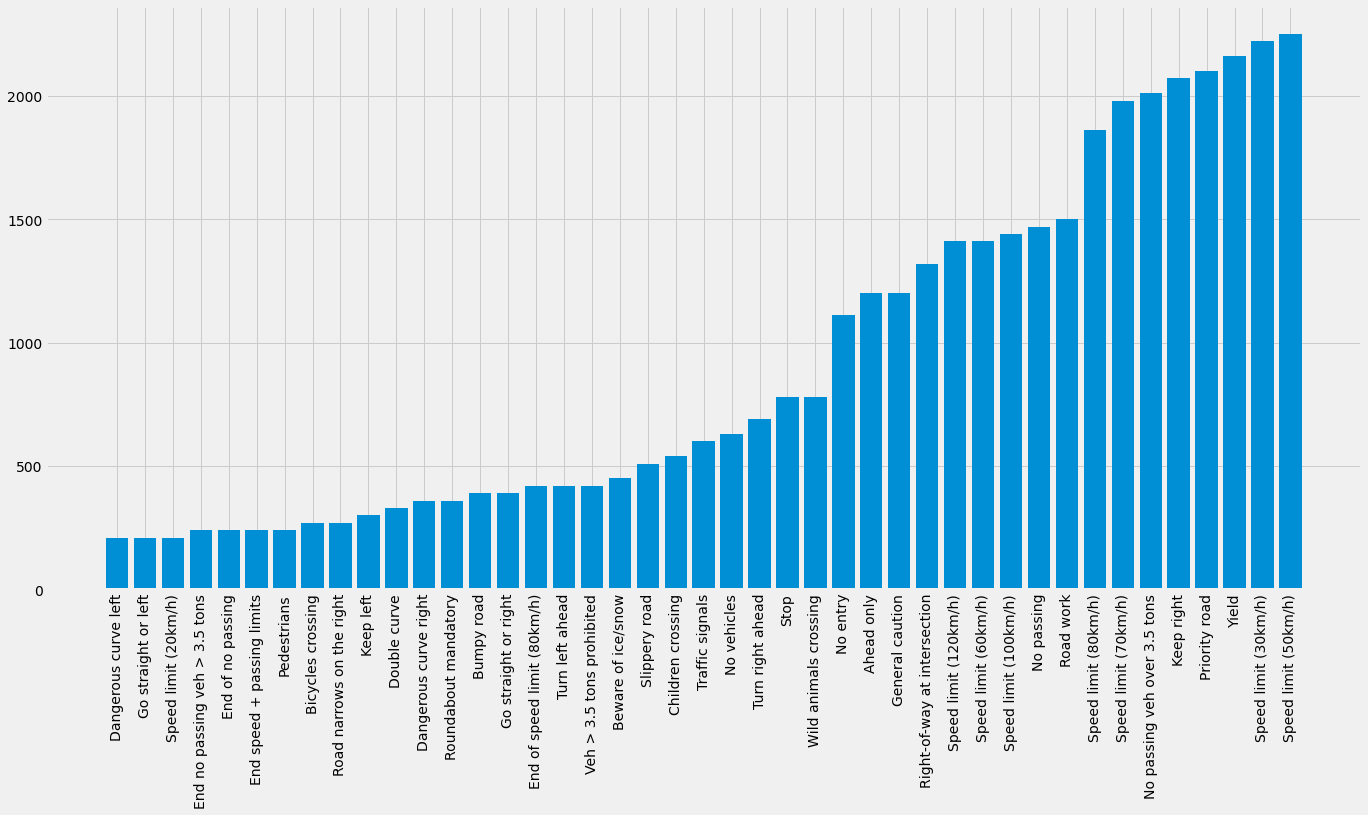

In [8]:
folders = os.listdir(train_path)

train_number = []
class_num = []

for folder in folders:
    train_files = os.listdir(train_path + '/' + folder)
    train_number.append(len(train_files))
    class_num.append(classes[int(folder)])
    
# Sorting the dataset on the basis of number of images in each class
zipped_lists = zip(train_number, class_num)
sorted_pairs = sorted(zipped_lists)
tuples = zip(*sorted_pairs)
train_number, class_num = [ list(tuple) for tuple in  tuples]

# Plotting the number of images in each class
plt.figure(figsize=(21,10))  
plt.bar(class_num, train_number)
plt.xticks(class_num, rotation='vertical')
plt.show()

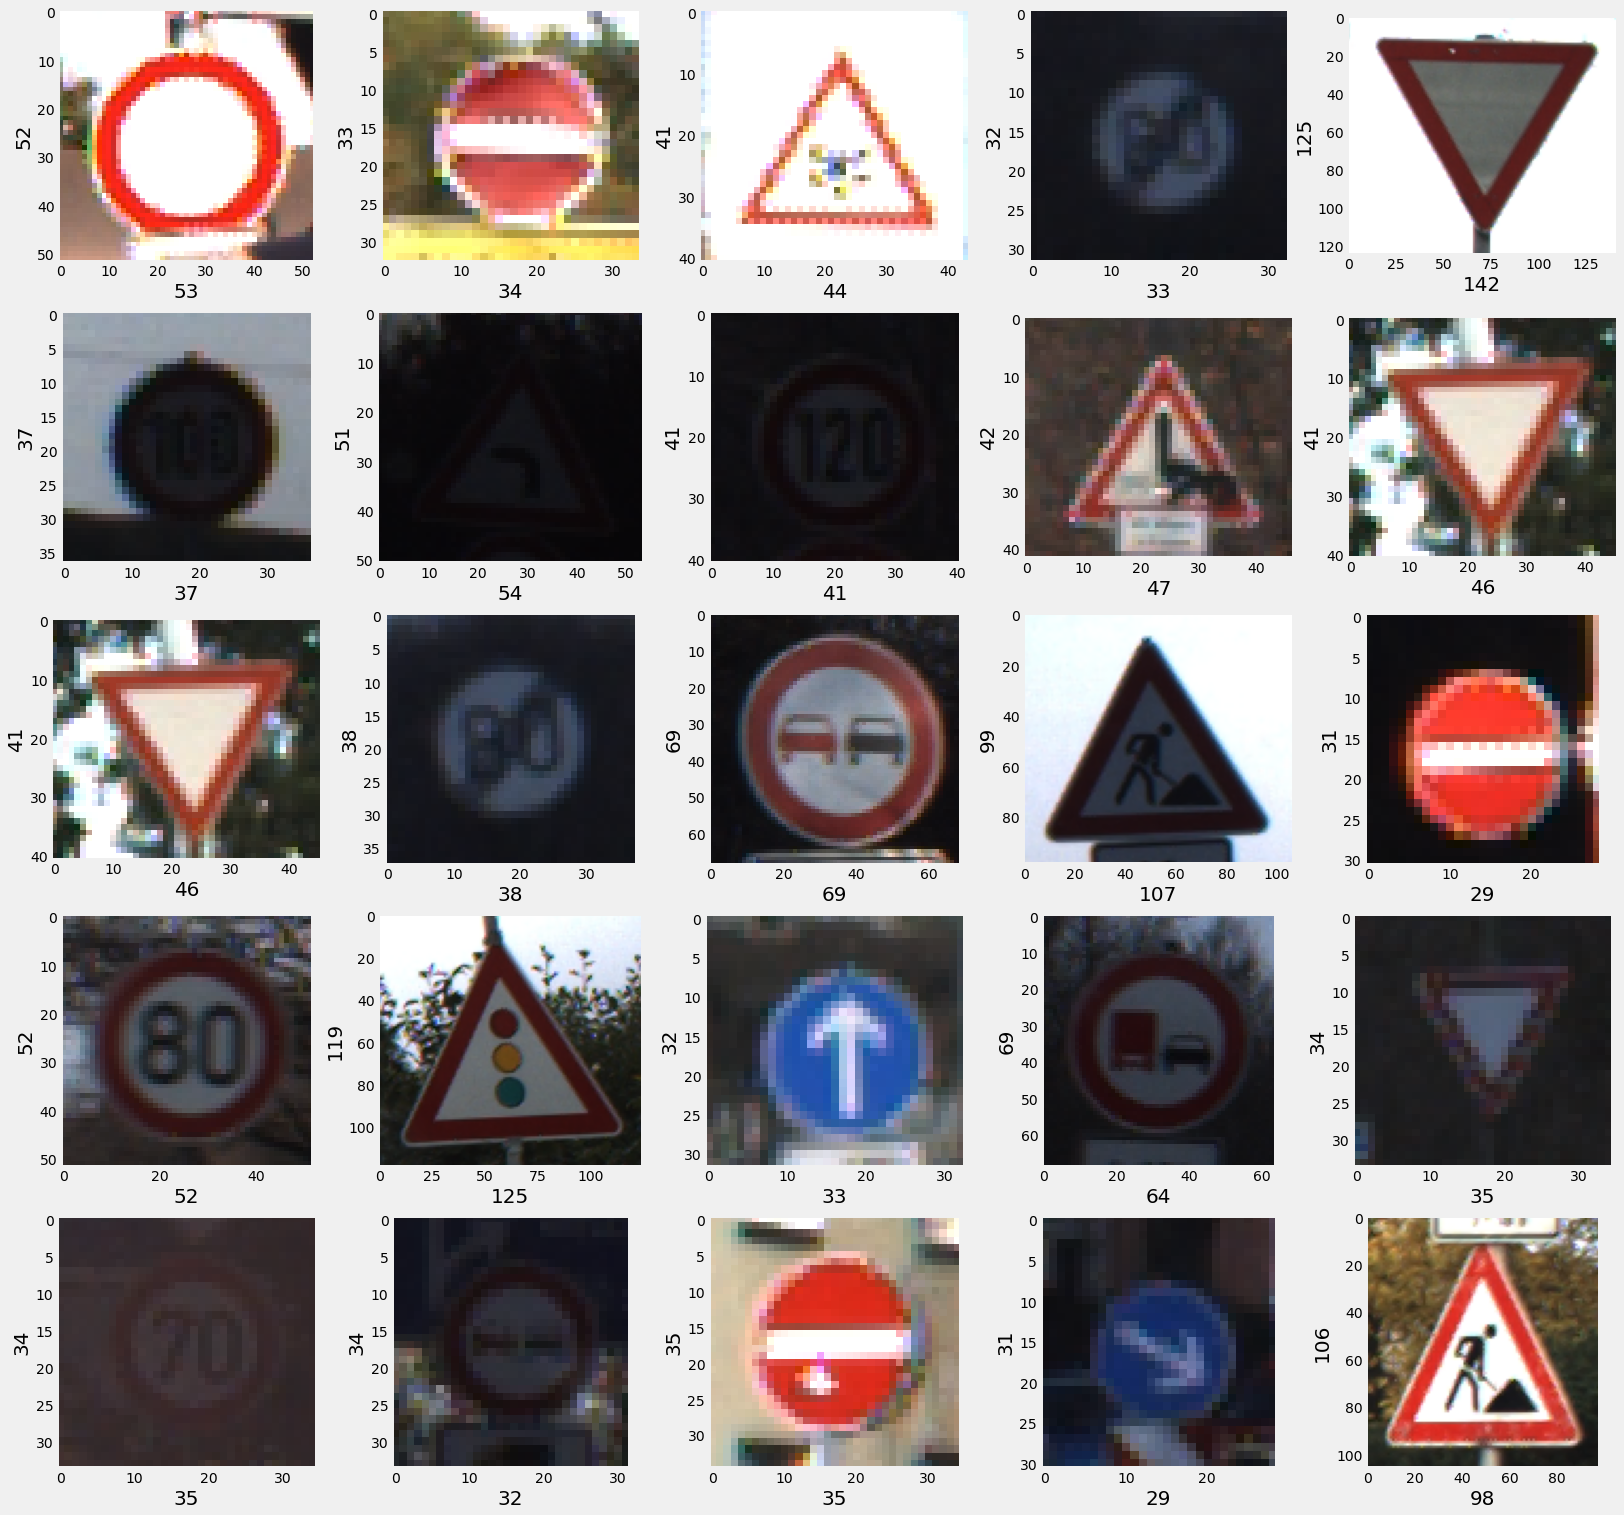

In [9]:
# Visualizing 25 random images from test data
import random
from matplotlib.image import imread

test = pd.read_csv(data_dir + '/Test.csv')
imgs = test["Path"].values

plt.figure(figsize=(25,25))

for i in range(1,26):
    plt.subplot(5,5,i)
    random_img_path = data_dir + '/' + random.choice(imgs)
    rand_img = imread(random_img_path)
    plt.imshow(rand_img)
    plt.grid(b=None)
    plt.xlabel(rand_img.shape[1], fontsize = 20)#width of image
    plt.ylabel(rand_img.shape[0], fontsize = 20)#height of image

In [10]:
image_data = []
image_labels = []

for i in range(NUM_CATEGORIES):
    path = data_dir + '/Train/' + str(i)
    images = os.listdir(path)

    for img in images:
        try:
            image = cv2.imread(path + '/' + img)
            image_fromarray = Image.fromarray(image, 'RGB')
            resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
            image_data.append(np.array(resize_image))
            image_labels.append(i)
        except:
            print("Error in " + img)

# Changing the list to numpy array
image_data = np.array(image_data)
image_labels = np.array(image_labels)

print(image_data.shape, image_labels.shape)

(39209, 30, 30, 3) (39209,)


In [11]:
shuffle_indexes = np.arange(image_data.shape[0])
np.random.shuffle(shuffle_indexes)
image_data = image_data[shuffle_indexes]
image_labels = image_labels[shuffle_indexes]

In [12]:
X_train, X_val, y_train, y_val = train_test_split(image_data, image_labels, test_size=0.3, random_state=42, shuffle=True)

X_train = X_train/255 
X_val = X_val/255

print("X_train.shape", X_train.shape)
print("X_valid.shape", X_val.shape)
print("y_train.shape", y_train.shape)
print("y_valid.shape", y_val.shape)

X_train.shape (27446, 30, 30, 3)
X_valid.shape (11763, 30, 30, 3)
y_train.shape (27446,)
y_valid.shape (11763,)


In [13]:
y_train = keras.utils.to_categorical(y_train, NUM_CATEGORIES)
y_val = keras.utils.to_categorical(y_val, NUM_CATEGORIES)

print(y_train.shape)
print(y_val.shape)

(27446, 43)
(11763, 43)


In [14]:
model = keras.models.Sequential([    
    keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', input_shape=(IMG_HEIGHT,IMG_WIDTH,channels)),
    keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),
    
    keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),
    
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(rate=0.5),
    
    keras.layers.Dense(43, activation='softmax')
])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [15]:
lr = 0.001
epochs = 30

opt = Adam(lr=lr, decay=lr / (epochs * 0.5))
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [16]:
aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest")

history = model.fit(aug.flow(X_train, y_train, batch_size=32), epochs=epochs, validation_data=(X_val, y_val))

Epoch 1/30
858/858 [==============================] - 92s 107ms/step - loss: 1.0736 - acc: 0.7144 - val_loss: 0.1008 - val_acc: 0.9685
Epoch 2/30
858/858 [==============================] - 92s 107ms/step - loss: 0.1660 - acc: 0.9493 - val_loss: 0.0975 - val_acc: 0.9675
Epoch 3/30
858/858 [==============================] - 95s 110ms/step - loss: 0.1010 - acc: 0.9699 - val_loss: 0.0156 - val_acc: 0.9957
Epoch 4/30
858/858 [==============================] - 92s 107ms/step - loss: 0.0805 - acc: 0.9767 - val_loss: 0.0130 - val_acc: 0.9956
Epoch 5/30
858/858 [==============================] - 92s 107ms/step - loss: 0.0606 - acc: 0.9812 - val_loss: 0.0213 - val_acc: 0.9927
Epoch 6/30
858/858 [==============================] - 95s 110ms/step - loss: 0.0552 - acc: 0.9830 - val_loss: 0.0141 - val_acc: 0.9960
Epoch 7/30
858/858 [==============================] - 91s 106ms/step - loss: 0.0444 - acc: 0.9862 - val_loss: 0.0075 - val_acc: 0.9977
Epoch 8/30
858/858 [==============================] - 9

In [21]:
model.save("model_krizz_4.h5")

In [22]:
model.save_weights("/content/drive/MyDrive/Deep_learning/Traffic_sign_classification/output4")

In [23]:
dir(aug)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_keras_api_names',
 '_keras_api_names_v1',
 '_validation_split',
 'apply_transform',
 'brightness_range',
 'channel_axis',
 'channel_shift_range',
 'col_axis',
 'cval',
 'data_format',
 'dtype',
 'featurewise_center',
 'featurewise_std_normalization',
 'fill_mode',
 'fit',
 'flow',
 'flow_from_dataframe',
 'flow_from_directory',
 'get_random_transform',
 'height_shift_range',
 'horizontal_flip',
 'interpolation_order',
 'mean',
 'preprocessing_function',
 'principal_components',
 'random_transform',
 'rescale',
 'rotation_range',
 'row_axis',
 'samplewise_center',
 'samplewise_std_normalization',
 'shear_range',
 'standa

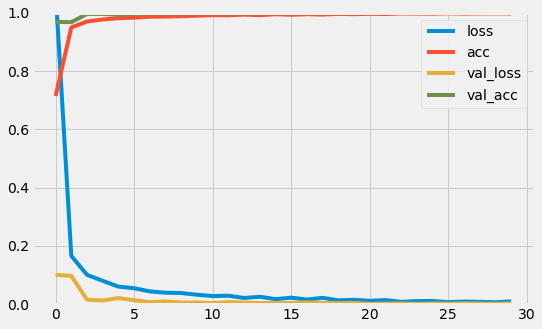

In [24]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [28]:
test = pd.read_csv(data_dir + '/Test.csv')

labels = test["ClassId"].values
imgs = test["Path"].values

data =[]
for img in imgs:
    try:
        image = cv2.imread(data_dir + '/' +img)
        image_fromarray = Image.fromarray(image, 'RGB')
        resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
        data.append(np.array(resize_image))
    except:
        print("Error in " + img)
X_test = np.array(data)
X_test = X_test/255

pred = model.predict_classes(X_test)

#Accuracy with the test data
print('Test Data accuracy: ',accuracy_score(labels, pred)*100)

Test Data accuracy:  98.47189231987332


In [29]:
from sklearn.metrics import confusion_matrix
cf = confusion_matrix(labels, pred)

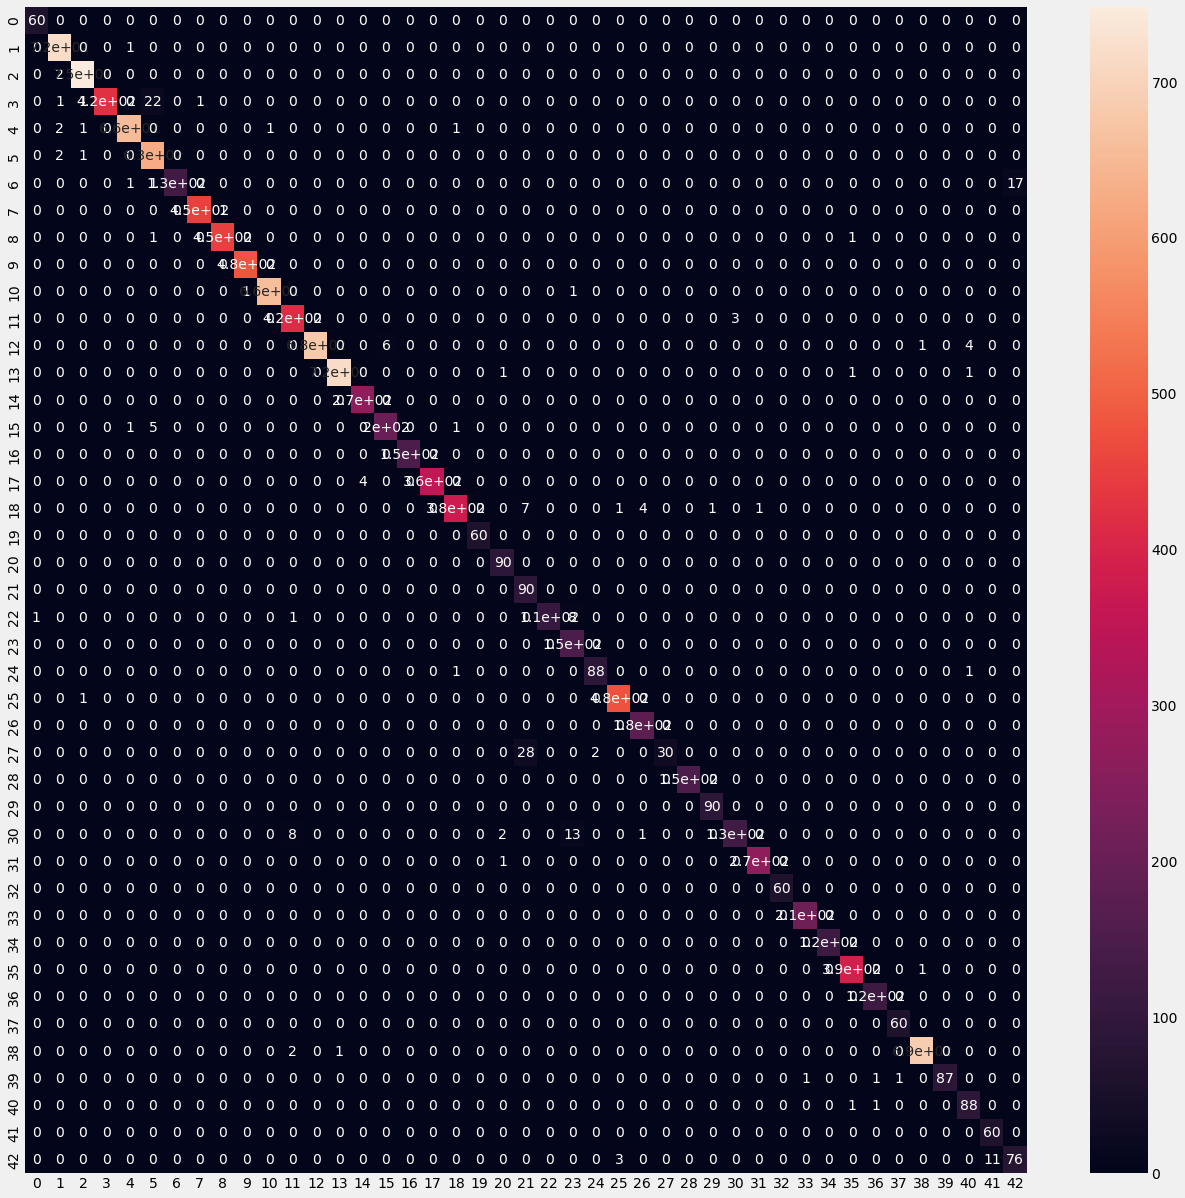

In [30]:
import seaborn as sns
df_cm = pd.DataFrame(cf, index = classes,  columns = classes)
plt.figure(figsize = (20,20))
sns.heatmap(df_cm, annot=True)

In [31]:

from sklearn.metrics import classification_report

print(classification_report(labels, pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99        60
           1       0.99      1.00      0.99       720
           2       0.99      1.00      1.00       750
           3       1.00      0.94      0.97       450
           4       1.00      0.99      0.99       660
           5       0.96      1.00      0.98       630
           6       1.00      0.87      0.93       150
           7       1.00      1.00      1.00       450
           8       1.00      1.00      1.00       450
           9       1.00      1.00      1.00       480
          10       1.00      1.00      1.00       660
          11       0.97      0.99      0.98       420
          12       1.00      0.98      0.99       690
          13       1.00      1.00      1.00       720
          14       0.99      1.00      0.99       270
          15       0.97      0.97      0.97       210
          16       1.00      1.00      1.00       150
          17       1.00    

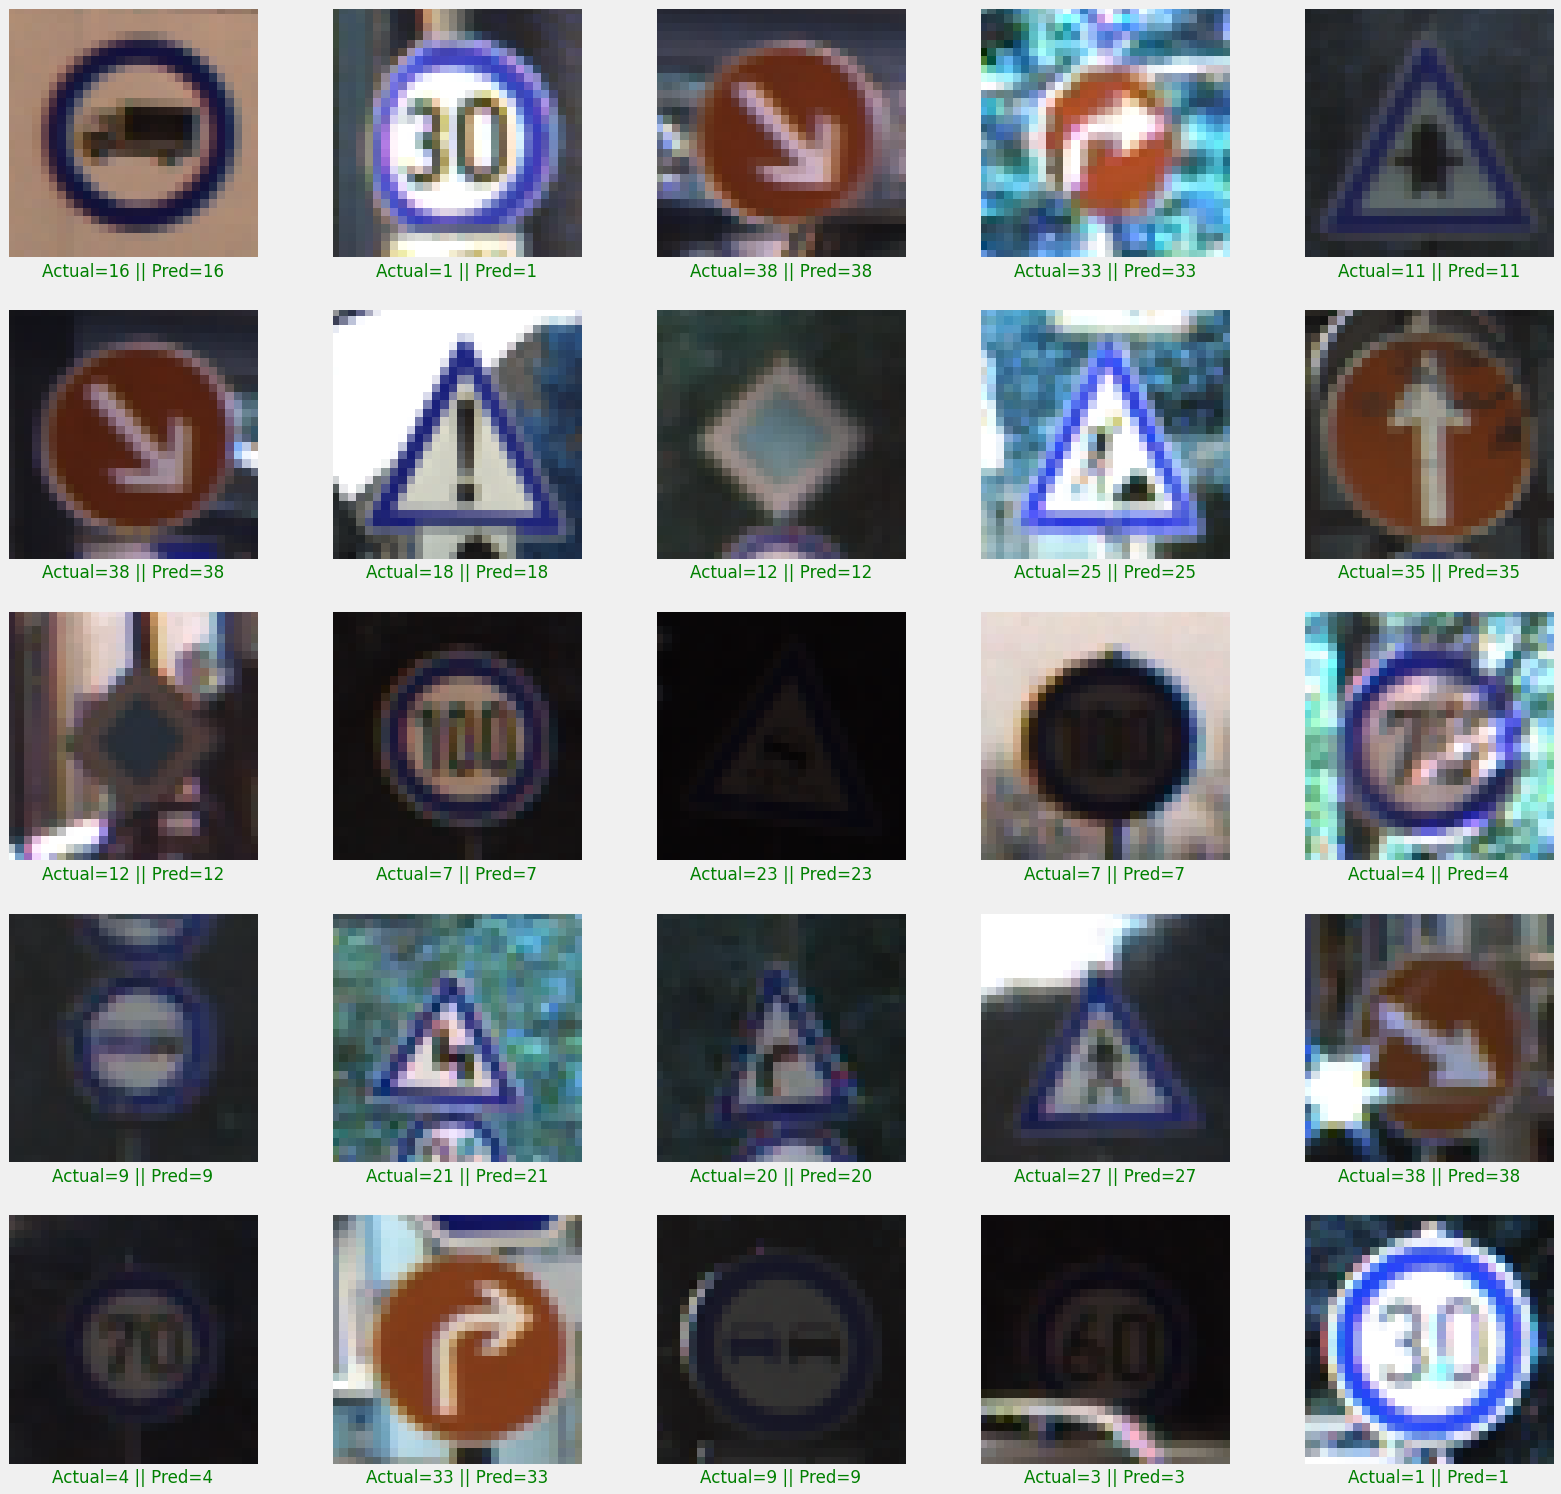

In [32]:
plt.figure(figsize = (25, 25))

start_index = 0
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    prediction = pred[start_index + i]
    actual = labels[start_index + i]
    col = 'g'
    if prediction != actual:
        col = 'r'
    plt.xlabel('Actual={} || Pred={}'.format(actual, prediction), color = col)
    plt.imshow(X_test[start_index + i])
plt.show()

In [33]:
ls

checkpoint    model_krizz_4.h5             output4.index
download.jpg  output2.data-00000-of-00002  Test/
logo.png      output2.data-00001-of-00002  Test.csv
Meta/         output2.index                Train/
Meta.csv      output4.data-00000-of-00002  Train.csv
model_2.h5    output4.data-00001-of-00002
